### This notebook takes code from `speculator`: https://github.com/justinalsing/speculator`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import astropy.units as u
import kuaizi

In [3]:
kuaizi.set_matplotlib(style='nature', usetex=False, dpi=100)
kuaizi.set_env(project='popsed', name='', data_dir='/scratch/gpfs/jiaxuanl/Data')

'/scratch/gpfs/jiaxuanl/Data/popsed/'

In [4]:
import sys
sys.path.append('/home/jiaxuanl/Research/popsed/')

In [5]:
pca_coeff = np.load('./train_sed/pca_coeffs.npy')
params = np.load('./train_sed/pca_params.npy')

# Normalize
pca_coeff_shift = np.mean(pca_coeff, axis=0)
pca_coeff_scale = np.std(pca_coeff, axis=0)
pca_coeff_scale[pca_coeff_scale == 0] = pca_coeff_scale[pca_coeff_scale == 0]

# params_shift = np.mean(params, axis=0)
# params_scale = np.std(params, axis=0)
# params_scale[params_scale == 0] = 1 # params_shift[params_scale == 0]

# pca_coeff = (pca_coeff - pca_coeff_shift) / pca_coeff_scale
# params = (params - params_shift) / params_scale

### Build NN emulator with FC

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from torch.utils.data import TensorDataset, DataLoader

In [7]:
from popsed.speculator import Network

In [198]:
# Translate data to tensor
x = torch.FloatTensor(params)
y = torch.FloatTensor(pca_coeff)
dataset = TensorDataset(x, y)
train_data, val_data = torch.utils.data.random_split(dataset, 
                                                     [1200, 400], 
                                                     generator=torch.Generator().manual_seed(42))

In [199]:
dataloaders = {}
dataloaders['train'] = DataLoader(train_data, batch_size=64, shuffle=True) # batch size is the size for each batch
dataloaders['val'] = DataLoader(val_data, batch_size=64) # batch size is the size for each batch

In [200]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x2b834f048610>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x2b834f048a60>}

$$a(\vec{x}) = [\vec{\beta} + (1 + \exp(-\vec{\alpha} \cdot \vec{x}))^{-1} (\vec{1} - \vec{\beta})] \cdot \vec{x}$$

In [90]:
def train_model(model, dataloaders):
    '''
    Train the model on the given dataloader
    '''
    train_loss_history = []
    val_loss_history = []
    
    learning_rate = 0.002
    epochs = 250
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        running_loss = 0.0
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = Variable(inputs)
                labels = Variable(labels)
            
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            if phase == 'train':
                train_loss_history.append(epoch_loss)
            if phase == 'val':
                val_loss_history.append(epoch_loss)
            
            if epoch % 10 == 0:
                print('Epoch: {} - {} Loss: {:.4f}'.format(epoch, phase, epoch_loss))

    return train_loss_history, val_loss_history

In [210]:
net = Network(9, [256, 256, 256], 30)

In [209]:
torch.FloatTensor(pca_coeff_scale).shape

torch.Size([30])

In [214]:
outputs = net(torch.ones([12, 9]))

In [92]:
train_loss_history, val_loss_history = train_model(net, dataloaders)

Epoch: 0 - train Loss: 0.0196
Epoch: 0 - val Loss: 0.0760
Epoch: 10 - train Loss: 0.0117
Epoch: 10 - val Loss: 0.0440
Epoch: 20 - train Loss: 0.0101
Epoch: 20 - val Loss: 0.0376
Epoch: 30 - train Loss: 0.0092
Epoch: 30 - val Loss: 0.0337
Epoch: 40 - train Loss: 0.0087
Epoch: 40 - val Loss: 0.0312
Epoch: 50 - train Loss: 0.0079
Epoch: 50 - val Loss: 0.0286
Epoch: 60 - train Loss: 0.0079
Epoch: 60 - val Loss: 0.0278
Epoch: 70 - train Loss: 0.0079
Epoch: 70 - val Loss: 0.0281
Epoch: 80 - train Loss: 0.0078
Epoch: 80 - val Loss: 0.0272
Epoch: 90 - train Loss: 0.0075
Epoch: 90 - val Loss: 0.0263
Epoch: 100 - train Loss: 0.0075
Epoch: 100 - val Loss: 0.0258
Epoch: 110 - train Loss: 0.0079
Epoch: 110 - val Loss: 0.0270
Epoch: 120 - train Loss: 0.0072
Epoch: 120 - val Loss: 0.0252
Epoch: 130 - train Loss: 0.0070
Epoch: 130 - val Loss: 0.0239
Epoch: 140 - train Loss: 0.0074
Epoch: 140 - val Loss: 0.0253
Epoch: 150 - train Loss: 0.0074
Epoch: 150 - val Loss: 0.0254
Epoch: 160 - train Loss: 0.006

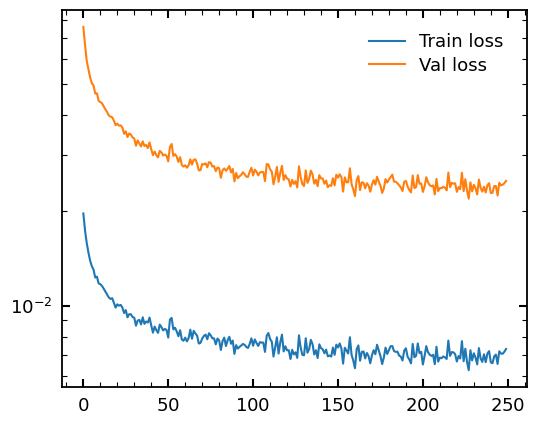

In [93]:
plt.plot(train_loss_history, label='Train loss')
plt.plot(val_loss_history, label='Val loss')
plt.legend()

plt.yscale('log')

In [367]:
import pickle

In [75]:
with open('./train_sed/pca_trained.pkl', 'rb') as f:
    pca = pickle.load(f)

In [76]:
log_spec_all = np.load('./train_sed/log_spec_all.npy')
param_all = np.load('./train_sed/param_all.npy')

In [71]:
net(x[[1100]]).detach().numpy() * pca_coeff_scale + pca_coeff_shift

array([[ 2.57691967e+00, -2.52071736e-01,  7.05716662e-03,
        -1.42363901e-03,  1.10746092e-04, -5.48496496e-04,
         4.08268759e-04, -3.07571167e-04,  3.53171249e-04,
        -1.08198561e-05]])

In [73]:
pca.training_pca[1100]

array([ 4.58946282e+00, -3.45356507e-01,  8.71410945e-03, -4.67536221e-03,
       -2.36364627e-03, -1.21215405e-03,  4.65842259e-06, -9.09626627e-04,
        5.20395215e-04, -1.28429754e-05])

In [259]:
pca.PCA.transform((log_spec_all[1100].reshape(1, -1) - pca.log_spectrum_shift) / pca.log_spectrum_scale)

array([[ 4.58946282e+00, -3.45356507e-01,  8.71410945e-03,
        -4.67536221e-03, -2.36364627e-03, -1.21215405e-03,
         4.65842259e-06, -9.09626627e-04,  5.20395215e-04,
        -1.28429754e-05]])

In [246]:
_y = pca.PCAtransform(log_spec_all[1100].reshape(1, -1) - pca.)

In [255]:
pca

IncrementalPCA(n_components=10)

In [254]:
x[1100]

tensor([ 5.0000e-02,  1.0000e+00, -5.0000e-01,  6.0000e-01,  1.0000e+00,
         9.3687e+00,  2.0000e+00,  0.0000e+00,  1.7358e-15])

In [375]:
net(x[[20]])

tensor([[ 0.3279,  1.5452, -0.6332, -2.3121, -0.3249, -0.0898,  1.9822, -1.1348,
         -1.5159,  1.2947]], grad_fn=<AddmmBackward0>)

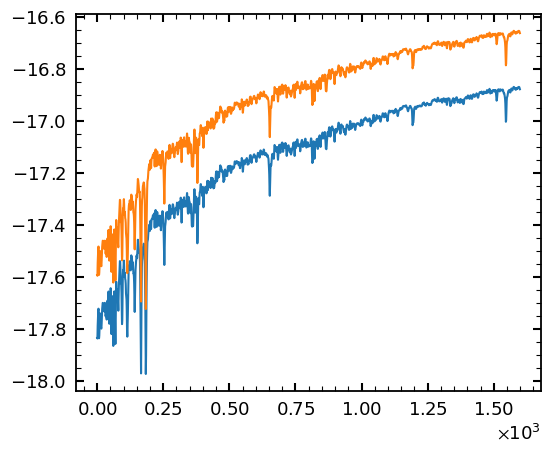

In [95]:
spec = pca.PCA.inverse_transform(
    net(x[[200]]).detach().numpy()[0] * pca_coeff_scale + pca_coeff_shift
) * pca.log_spectrum_scale + pca.log_spectrum_shift# + 1.5

plt.plot(log_spec_all[200])
plt.plot(spec)

### Test the `Speculator` class

In [5]:
from popsed.speculator import Speculator

In [6]:
flag = np.array([ True,  True,  True,  True,  True, False,  True,  True, False])

In [35]:
speculator = Speculator(n_parameters=2, n_pca_components=30, 
                        pca_filename='./train_sed/pca_trained.pkl', 
                        hidden_size=[256, 256, 256])

In [36]:
zero_flag = (np.mean(np.load('./train_sed/log_spec_all.npy'), axis=1) < -30)

In [37]:
log_spec_all = np.load('./train_sed/log_spec_all.npy')[~zero_flag]
pca_coeff = np.load('./train_sed/pca_coeffs.npy')[~zero_flag]
params = np.load('./train_sed/pca_params.npy')[:, ~flag][~zero_flag]

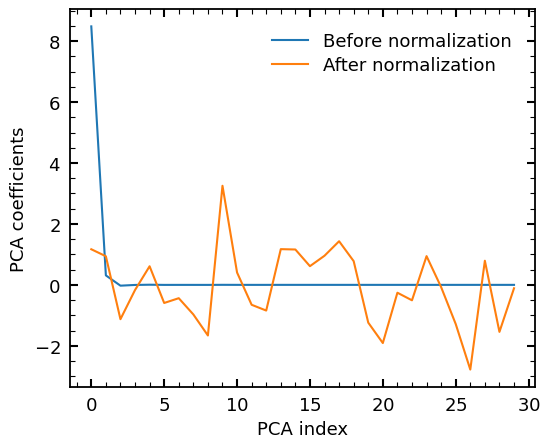

In [28]:
#ind = np.random.randint(0, high=1600, size=10)
plt.plot((pca_coeff[180]), label='Before normalization');
plt.plot((pca_coeff[180] - speculator.pca_shift) / speculator.pca_scale, label='After normalization');

plt.xlabel('PCA index')
plt.ylabel('PCA coefficients')
plt.legend()

In [29]:
# pca_shift = np.mean(pca_coeff, axis=0)
# pca_scale = np.std(pca_coeff, axis=0)
# pca_coeff = (pca_coeff - pca_shift) / pca_scale

In [38]:
speculator.load_data(pca_coeff, params, val_frac=0.1, batch_size=64)

In [39]:
speculator.train(learning_rate=2e-3, n_epochs=200)

Epoch: 0 - train Loss: 0.0305
Epoch: 0 - val Loss: 0.2865
Epoch: 10 - train Loss: 0.0182
Epoch: 10 - val Loss: 0.1715
Epoch: 20 - train Loss: 0.0132
Epoch: 20 - val Loss: 0.1236
Epoch: 30 - train Loss: 0.0098
Epoch: 30 - val Loss: 0.0923
Epoch: 40 - train Loss: 0.0079
Epoch: 40 - val Loss: 0.0740
Epoch: 50 - train Loss: 0.0066
Epoch: 50 - val Loss: 0.0613
Epoch: 60 - train Loss: 0.0067
Epoch: 60 - val Loss: 0.0621
Epoch: 70 - train Loss: 0.0066
Epoch: 70 - val Loss: 0.0602
Epoch: 80 - train Loss: 0.0055
Epoch: 80 - val Loss: 0.0503
Epoch: 90 - train Loss: 0.0053
Epoch: 90 - val Loss: 0.0487
Epoch: 100 - train Loss: 0.0054
Epoch: 100 - val Loss: 0.0498
Epoch: 110 - train Loss: 0.0047
Epoch: 110 - val Loss: 0.0432
Epoch: 120 - train Loss: 0.0054
Epoch: 120 - val Loss: 0.0493
Epoch: 130 - train Loss: 0.0048
Epoch: 130 - val Loss: 0.0443
Epoch: 140 - train Loss: 0.0053
Epoch: 140 - val Loss: 0.0486
Epoch: 150 - train Loss: 0.0045
Epoch: 150 - val Loss: 0.0412
Epoch: 160 - train Loss: 0.004

In [40]:
# for lr in [2e-3, 1e-4, 1e-5]:
#     speculator.train(learning_rate=lr, n_epochs=200)

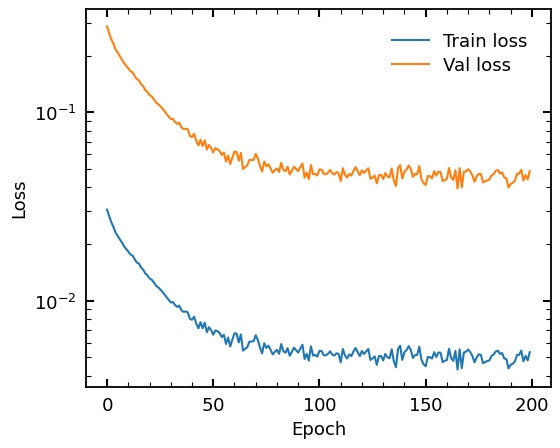

In [42]:
speculator.plot_loss()

In [43]:
params = np.load('./train_sed/pca_params.npy')[:, ~flag]
log_spec_all = np.load('./train_sed/log_spec_all.npy')

In [44]:
# _pca_coeff = speculator.predict(params)

In [45]:
_specs = speculator.predict_spec(params)

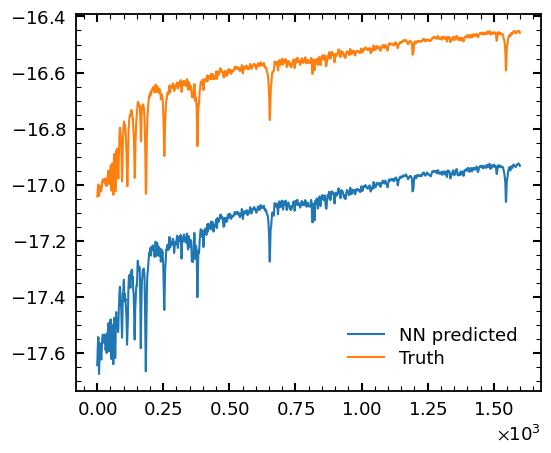

In [46]:
plt.plot(_specs[100], label='NN predicted')
plt.plot(log_spec_all[100], label='Truth')

plt.legend()